In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import pickle
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, TensorDataset, RandomSampler

In [2]:
root = '/home/deeksha/Documents/MLSP/derivatives/'


## Data Loader strategy

### 1. Load all data of a subject in session 1 and session 2 (dont load 3, because noisy)
### 2. select only inner speech Y[:, 2] ==1
### 3. Stack all subjects recordings along batch axis = 0 (n_recording * n_subjects, 128, 1153)

In [3]:
class get_loader(nn.Module):
    
    def __init__(self, root_dir, n_sess = 2, mode = 1):
        '''
        root_dir: the main folder with subject-wise subfolders
        n_sess:   number of sessions to consider. 1/2/3
        mode:     0-pronounced 
                  1-inner 
                  2-visualized
                  
        '''
        super(get_loader, self).__init__()
        self.root_dir = root_dir
        self.n_sess = n_sess
        self.mode = mode #condition
        
    def load_single_subject(self, sub_idx):
        '''
        sub_idx: 1, 2, ..... integers
        '''
        data = dict()
        y = dict()
        N_B_arr = np.arange(1, self.n_sess+1, 1)
        N_S = sub_idx
        print(N_S)
        for N_B in N_B_arr:
            
            # name correction if N_Subj is less than 10
            if N_S<10:
                Num_s='sub-0'+str(N_S)
            else:
                Num_s='sub-'+str(N_S)
            
            file_name = root  + Num_s + '/ses-0'+ str(N_B) + '/' +Num_s+'_ses-0'+str(N_B)+'_events.dat'
            y[N_B] = np.load(file_name,allow_pickle=True)
        
        
            #  load data and events
            file_name = root  + Num_s + '/ses-0'+ str(N_B) + '/' +Num_s+'_ses-0'+str(N_B)+'_eeg-epo.fif'
            X= mne.read_epochs(file_name,verbose='WARNING')
            data[N_B]= X._data    
         
        #stack the sessions
        X = data.get(1)
        Y = y.get(1)
        for i in range(2, self.n_sess+1, 1):
            X = np.vstack((X, data.get(i)))
            Y = np.vstack((Y, y.get(i)))
        
        #select the recordings from required mode only
        X_mode = X[Y[:,2] == self.mode]
        Y_mode = Y[Y[:, 2] == self.mode]
        
        return X_mode, Y_mode
    
    def load_multiple_subjects(self, subjects):
        '''
        Load all subjects required and stack them into single array (n_rec*n_sub, 128, 1153)
        '''
        X_t, Y_t = [], []
        for idx in subjects:
            Xi, Yi = self.load_single_subject(idx)
            X_t.append(Xi)
            Y_t.append(Yi)
    
        return np.vstack(X_t), np.vstack(Y_t)
    
    def forward(self, subjects, batch_size = 1):
        '''
        subjects: list of subject indices to load data from
        '''
        X, Y = self.load_multiple_subjects(subjects)
        X = torch.tensor(X)
        Y = torch.tensor(Y)
        
        train_data = TensorDataset(X, Y)
        train_sampler = RandomSampler(X)
        train_dataloader = DataLoader(X, sampler=train_sampler, batch_size=batch_size)
                  
        # can add test/validation loader too 
        
        return train_dataloader

## Clustering

In [4]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [5]:
creater = get_loader(root, mode=1)
#loader = creater([1, 2])
#test_loader = creater([3, 4])

In [6]:
X, yn = creater.load_multiple_subjects([1, 2, 3, 4, 5, 6, 7, 8]) 

1
2
3
4
5
6
7
8


In [7]:
X = X.reshape(-1, 128*1153)
y = yn[:, 1]

print(X.shape)

(1240, 147584)


### PCA transform

In [8]:
var = 0.98
pca = PCA(var)
pca.fit(X)

PCA(n_components=0.98)

In [9]:
print("Number of components before PCA  = " + str(X.shape[1]))
print("Number of components after PCA 0.98 = " + str(pca.n_components_))

Number of components before PCA  = 147584
Number of components after PCA 0.98 = 1038


In [10]:
Clus_dataSet = pca.transform(X)
print("Dimension of our data after PCA = " + str(Clus_dataSet.shape))


Dimension of our data after PCA = (1240, 1038)


### Kmeans clustering

In [11]:
del X

In [44]:
np.random.seed(33)
k_means = KMeans(init = "k-means++", n_clusters = 4, n_init = 10)
k_means.fit(Clus_dataSet)
k_means_labels = k_means.predict(Clus_dataSet)


### Visualise

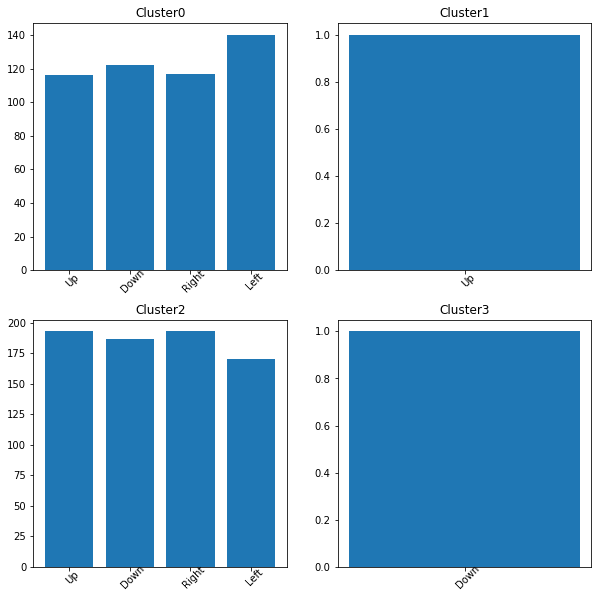

In [45]:
G = len(np.unique(k_means_labels)) #Number of labels
#2D matrix  for an array of indexes of the given label
cluster_index= [[] for i in range(G)]
for i, label in enumerate(k_means_labels,0):
    for n in range(G):
        if label == n:
            cluster_index[n].append(i)
        else:
            continue

def counter(cluster):
    unique, counts = np.unique(cluster, return_counts=True)
    label_index = dict(zip(unique, counts))
    return label_index

Y_clust = [[] for i in range(G)]
for n in range(G):
    Y_clust[n] = y[cluster_index[n]] #Y_clust[0] contains array of "correct" category from y_train for the cluster_index[0]
    assert(len(Y_clust[n]) == len(cluster_index[n])) 
    
    
label_count= [[] for i in range(G)]
for n in range(G):
    label_count[n] = counter(Y_clust[n])

class_names = {0:'Up', 1:'Down',2: 'Right',3: 'Left'} #Dictionary of class names

#A function to plot a bar graph for visualising the number of items of certain category in a cluster
def plotter(label_dict):
    plt.bar(range(len(label_dict)), list(label_dict.values()), align='center')
    a = []
    for i in [*label_dict]: a.append(class_names[i])
    plt.xticks(range(len(label_dict)), list(a), rotation=45, rotation_mode='anchor')
    
plt.figure(figsize=(10,10))
for i in range (1,5):
    plt.subplot(2, 2, i)
    plotter(label_count[i-1]) 
    plt.title("Cluster" + str(i-1))

## 

In [ ]:
#!pip install chart_studio 
#!pip install plotly
#!pip install nbformat
#!pip install plotly_express==0.4.0

In [ ]:
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
#3D Plotly Visualization of Clusters using go
layout = go.Layout(
    title='<b>Cluster Visualisation</b>',
    yaxis=dict(
        title='<i>Y</i>'
    ),
    xaxis=dict(
        title='<i>X</i>'
    )
)
colors = ['magenta','yellow','teal','black']
trace = [ go.Scatter3d() for _ in range(5)]
for i in range(0,4):
    my_members = (k_means_labels == i)
    index = [h for h, g in enumerate(my_members) if g]
    trace[i] = go.Scatter3d(
            x=Clus_dataSet[my_members, 0],# 0 is a component among the 420 components. Feel free to change it
            y=Clus_dataSet[my_members, 1],# 1 is a component among the 420 components. Feel free to change it
            z=Clus_dataSet[my_members, 2],# 2 is a component among the 420 components. Feel free to change it
            mode='markers',
            marker = dict(size = 2,color = colors[i]),
            hovertext=index,
            name='Cluster'+str(i),
   
            )
fig = go.Figure(data=[trace[0],trace[1],trace[2],trace[3]])
py.offline.iplot(fig)


# K medoids

In [46]:
from sklearn_extra.cluster import KMedoids

In [57]:
np.random.seed(42)
k_meds= KMedoids(init = "k-medoids++", n_clusters = 4, method = 'pam', metric = 'l1', max_iter = 25)
k_meds.fit(Clus_dataSet)
k_meds_labels = k_meds.predict(Clus_dataSet)


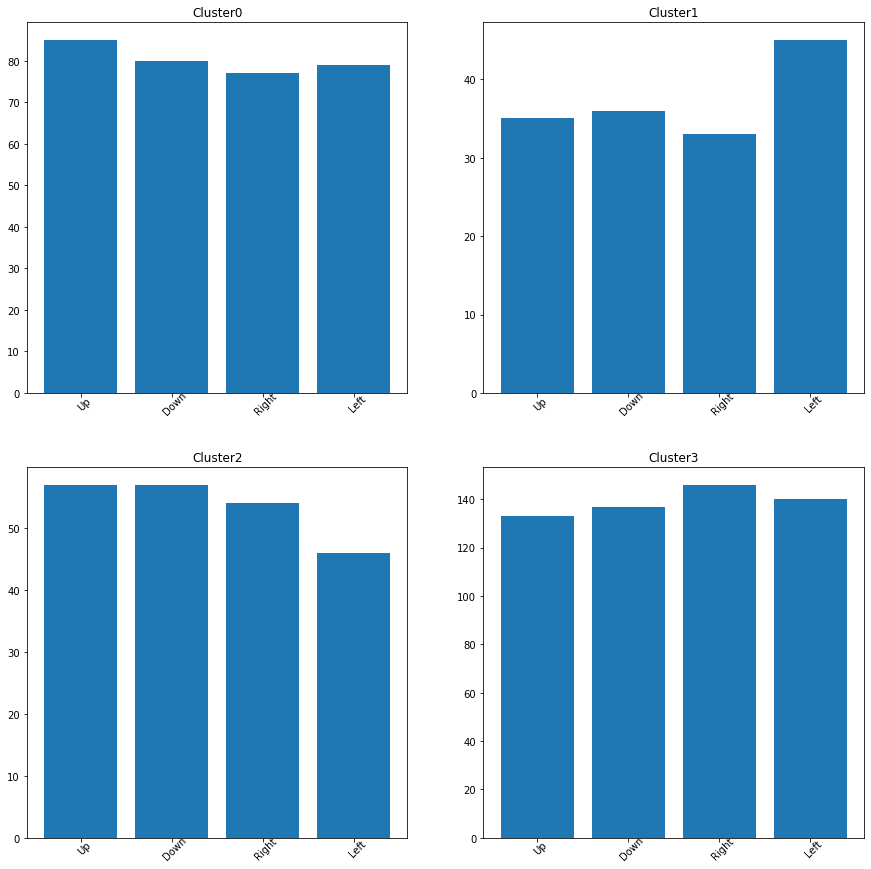

In [58]:
G = len(np.unique(k_meds_labels)) #Number of labels
#2D matrix  for an array of indexes of the given label
cluster_index= [[] for i in range(G)]
for i, label in enumerate(k_meds_labels,0):
    for n in range(G):
        if label == n:
            cluster_index[n].append(i)
        else:
            continue

def counter(cluster):
    unique, counts = np.unique(cluster, return_counts=True)
    label_index = dict(zip(unique, counts))
    return label_index

Y_clust = [[] for i in range(G)]
for n in range(G):
    Y_clust[n] = y[cluster_index[n]] #Y_clust[0] contains array of "correct" category from y_train for the cluster_index[0]
    assert(len(Y_clust[n]) == len(cluster_index[n])) 
    
    
label_count= [[] for i in range(G)]
for n in range(G):
    label_count[n] = counter(Y_clust[n])

class_names = {0:'Up', 1:'Down',2: 'Right',3: 'Left'} #Dictionary of class names

#A function to plot a bar graph for visualising the number of items of certain category in a cluster
def plotter(label_dict):
    plt.bar(range(len(label_dict)), list(label_dict.values()), align='center')
    a = []
    for i in [*label_dict]: a.append(class_names[i])
    plt.xticks(range(len(label_dict)), list(a), rotation=45, rotation_mode='anchor')
    
plt.figure(figsize=(15,15))
for i in range (1,5):
    plt.subplot(2, 2, i)
    plotter(label_count[i-1]) 
    plt.title("Cluster" + str(i-1))